In [1]:
import numpy as np
import pandas as pd
import copy
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
class Elevator(object):
    """An Elevator is a generic class that can move one floor up and down and
    let the passengers off and on simultaneously with the help of a convenience function called "open_door".
    """

    def __init__(self, building, capacity = 10):
        """Initializes an instance of a class with a certain capacity identified by the user.
        Each object is characterized by the number of passengers, its current floor, the building
        where it is situated, and a list of passengers inside the elevator.
        """
        self.capacity = capacity   # number of people elevator can hold
        self.current_floor = 1     # elevator starts at ground floor: 1
        self.building = building
        self.num_passengers = 0

        # self.passengers is a dictionary from a destination floor number
        # to a list of Passenger objects (the Passengers that need to get off at floor i)
        self.passengers = { 
            i : [] for i in range(1, building.num_floors + 1)
        }


    def move(self, direction):
        """Moves the elevator one floor up or down. """
        self.current_floor += direction # direction is integer +1 or -1

    def let_off(self, passenger, timestep = None):
        """Removes `passenger` from the elevator and adds them to the building.
        If `passenger` has arrived on their destination floor, add them to `arrived_passengers`.
        Raises an error if `passenger` is not on the elevator.
        """
        try:
            self.passengers[passenger.end_floor].remove(passenger)
        except:
            raise("Passenger not found on elevator!")
        self.num_passengers -= 1

        if passenger.end_floor == self.current_floor:
            self.building.arrived_passengers.append(passenger)
        else:
            self.building.waiting_passengers[self.current_floor].append(passenger)
            self.building.num_passengers += 1

        if timestep is not None:
            passenger.travel_time += timestep - passenger.last_boarding
            passenger.last_deboarding = timestep

        return

    def let_on(self, passenger, timestep = None):
        """Adds `passenger` to the elevator from the current floor
        Raises an error if `passenger` is not on the elevator's current_floor
        """
        try:
            self.building.waiting_passengers[self.current_floor].remove(passenger)
        except:
            raise("Passenger not found on current floor!")
        self.building.num_passengers -= 1

        self.passengers[passenger.end_floor].append(passenger)
        self.num_passengers += 1

        if timestep is not None:
            passenger.wait_time += timestep - passenger.last_deboarding
            passenger.last_boarding = timestep

        return

    def open_doors(self, timestep = None):
        """A convenience function for letting people on and off floors simultaneously"""

        # passengers get off
        for passenger in self.passengers[self.current_floor]:
            self.let_off(passenger, timestep)

        # passengers get on
        floor_lst = self.building.waiting_passengers[self.current_floor]
        while self.capacity > self.num_passengers and floor_lst:
            passenger = floor_lst[-1]
            self.let_on(passenger, timestep)

        return

    def not_empty(self):
        """Returns True if elevator is not empty."""
        return self.num_passengers > 0

class Building(object):
    """The building generates and stores the passengers waiting for the elevator."""

    def __init__(self, num_floors, num_passengers):
        """By default requires user specified number of floors and passengers."""
        self.num_floors = num_floors
        self.arrived_passengers = []
        self.waiting_passengers = { 
            i : [] for i in range(1, num_floors + 1)
        }
        self.num_passengers = 0
        self.add_passengers_randomly(num_passengers)

    def add_passengers_randomly(self, number):
        """Generates random passengers added to each floor."""
        for i in range(number):
            start = np.random.randint(1, self.num_floors + 1)
            end = start
            while end == start:
                end = np.random.randint(1, self.num_floors + 1)
            passenger = Passenger(start,end)
            self.waiting_passengers[passenger.start_floor].append(passenger)
        self.num_passengers += number

    def not_empty(self):
        """Returns True if building is not empty."""
        return self.num_passengers > 0

class Passenger(object):
    """Initiates passengers with start and end floor, called in building class."""

    def __init__(self, start_floor, end_floor):
        """Initializes variables for keeping track of wait_ and travel_time
        Allows for multiple boardings/deboardings from the elevator
        """
        self.start_floor = start_floor
        self.end_floor = end_floor
        self.last_boarding = 0
        self.last_deboarding = 0
        self.wait_time = 0
        self.travel_time = 0

In [3]:
# Main Program

def display_state(elevator, building, analytics):
    """Displays the current number of passengers in building and elevator."""
    print ((building.num_passengers,elevator.num_passengers))

def run_simulation(elevator,building,strategy,log_progress=True):
    """Runs the simulation for a given strategy.
       Continues to call the given strategy until
       all passengers are processed.
    """
    is_moving_up = True
    timestep = 0
    analytics = {'waiting_times':[]}
    while building.not_empty() or elevator.not_empty():
        timestep,is_moving_up = strategy(elevator,building,timestep,is_moving_up)
        if log_progress:
            display_state(elevator, building, analytics)
    analytics['tot_time'] = timestep
    analytics['arrived_passengers'] = building.arrived_passengers

    return analytics

def basic_controller(elevator, building, timestep, is_moving_up):
    """Implements basic elevator strategy.
       Elevator goes up and down the building,
       stopping at every floor along the way.
    """
    elevator.open_doors(timestep = timestep)
    timestep += 1

    # switch directions if the elevator reaches the top or bottom of the building
    if elevator.current_floor == building.num_floors:
        is_moving_up = False
    elif elevator.current_floor == 1:
        is_moving_up = True

    # elevator moves up or down
    elevator.move(1 if is_moving_up else -1)

    timestep += 1

    return(timestep,is_moving_up)

def secondary_controller(elevator, building, timestep,is_moving_up):
    """Implements an elevator strategy where the
       elevator goes up and down the building,
       stopping at every floor where someone needs to get off or on.
    """
    if elevator.current_floor == building.num_floors:
        is_moving_up = False
    elif elevator.current_floor == 1:
        is_moving_up = True

    on_floor = building.waiting_passengers[elevator.current_floor]
    off_floor = elevator.passengers[elevator.current_floor]
    space = True if elevator.num_passengers < elevator.capacity else False

    if (off_floor) or (on_floor and space):
        elevator.open_doors(timestep = timestep)
    else:
        # switch directions if the elevator reaches the top or bottom of the building
        elevator.move(1 if is_moving_up else -1)

    # elevator moves up or down
    timestep += 1
    return(timestep,is_moving_up)

if __name__ == "__main__":

    # create building object with random passenger set up
    building1 = Building(num_floors=20, num_passengers=100)

    # an identical copy of the building
    building2 = copy.deepcopy(building1)

    # two elevators, each with its own associated building
    elevator1 = Elevator(building1, capacity=10)
    elevator2 = Elevator(building2, capacity=10)

    # run simulations with each of the two strategies
    print("Simulation: Strategy 1")
    results1 = run_simulation(elevator1, building1, basic_controller)
    print("Simulation: Strategy 2")
    results2 = run_simulation(elevator2, building2, secondary_controller)

Simulation: Strategy 1
(96, 4)
(95, 5)
(92, 8)
(90, 10)
(90, 10)
(89, 10)
(89, 10)
(89, 10)
(88, 10)
(88, 10)
(87, 10)
(86, 10)
(86, 10)
(85, 10)
(84, 10)
(84, 10)
(83, 10)
(82, 10)
(81, 10)
(80, 10)
(80, 10)
(79, 10)
(78, 10)
(78, 10)
(78, 10)
(76, 10)
(76, 10)
(75, 10)
(75, 10)
(74, 10)
(73, 10)
(73, 10)
(72, 10)
(70, 10)
(69, 10)
(68, 10)
(68, 10)
(68, 10)
(68, 9)
(68, 9)
(68, 9)
(68, 9)
(67, 10)
(66, 10)
(66, 10)
(66, 10)
(66, 10)
(66, 10)
(66, 10)
(65, 10)
(64, 10)
(63, 10)
(63, 10)
(62, 10)
(62, 10)
(61, 10)
(61, 10)
(59, 10)
(58, 10)
(58, 10)
(57, 10)
(56, 10)
(56, 10)
(55, 10)
(55, 10)
(55, 10)
(55, 10)
(54, 10)
(54, 10)
(53, 10)
(52, 10)
(52, 10)
(51, 10)
(51, 9)
(51, 9)
(51, 8)
(51, 7)
(51, 7)
(51, 7)
(51, 6)
(48, 9)
(46, 10)
(46, 10)
(46, 10)
(46, 10)
(46, 10)
(46, 10)
(45, 10)
(44, 10)
(43, 10)
(41, 10)
(41, 9)
(41, 9)
(39, 10)
(38, 10)
(37, 10)
(37, 10)
(37, 10)
(37, 10)
(37, 9)
(35, 10)
(34, 10)
(33, 10)
(32, 10)
(31, 10)
(31, 10)
(31, 10)
(30, 10)
(30, 10)
(29, 10)
(29, 

## Efficiency Comparison

In [4]:
def extract_times(results,strategy):
    """Extract efficiency metrics from stored passenger objects."""

    waited = [] # times waiting for elevator
    travelled = [] # times on elevator
    totals = [] # total times travelled

    # add every passengers data to aggregate lists
    for passenger in results['arrived_passengers']:
        waited.append(passenger.wait_time)
        travelled.append(passenger.travel_time)
        totals.append(passenger.wait_time+passenger.travel_time)

    # update dictionary with extracted data
    strategy["runtimes"].append(results["tot_time"])
    strategy["waits"].append(waited)
    strategy["travels"].append(travelled)
    strategy["totals"].append(totals)


def compare_strategies(strategies,runs=100):
    """Run simulation 'runs' times for each strategy and extract efficiency metrics."""

    metrics = []
    # create a metric dictionary for each strategy
    for strategy in strategies:
        metrics.append({"runtimes":[],"waits":[],"travels":[],"totals":[]})

    # run the simulation for each strategy, 'runs' times
    for sim_run in range(runs):
        basic_building = Building(num_floors=20, num_passengers=100)
        buildings = []
        elevators = []
        results = []
        for i,strategy in enumerate(strategies):
            building = copy.deepcopy(basic_building)
            elevator = Elevator(building, capacity=10)
            results = run_simulation(elevator,building,strategy,log_progress=False)
            extract_times(results,metrics[i])

    return(metrics)

In [5]:
# collect efficiency measures for each strategy developed
strategies = [basic_controller,secondary_controller]
strategy1,strategy2 = compare_strategies(strategies,1000)

In [6]:
# simple tabular summary of simulation runtimes under each strategy

pd.DataFrame([strategy1["runtimes"],strategy2["runtimes"]],
             index=['Strategy 1','Strategy 2']).T.describe()

,Strategy 1,Strategy 2
count,1000.000000,1000.000000
mean,451.708000,279.009000
std,43.827521,19.241808
min,336.000000,234.000000
25%,420.000000,259.000000
50%,456.000000,279.000000
75%,470.000000,296.000000
max,610.000000,343.000000


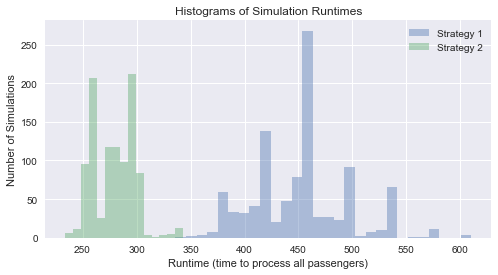

In [7]:
plt.figure(figsize=(8,4))
sns.distplot(strategy1["runtimes"],label='Strategy 1',kde=False)
sns.distplot(strategy2["runtimes"],label='Strategy 2',kde=False)
plt.title('Histograms of Simulation Runtimes')
plt.ylabel('Number of Simulations')
plt.xlabel('Runtime (time to process all passengers)')
plt.legend()
plt.show()

In [8]:
def all_waiting_times(times):
    """Simple helper function to merge list of lists."""
    return([time for simulation in times for time in simulation])

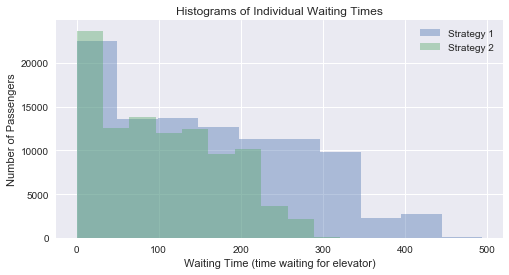

In [9]:
plt.figure(figsize=(8,4))
sns.distplot(all_waiting_times(strategy1['waits']),label='Strategy 1',kde=False,bins=10)
sns.distplot(all_waiting_times(strategy2['waits']),label='Strategy 2',kde=False,bins=10)
plt.title('Histograms of Individual Waiting Times')
plt.ylabel('Number of Passengers')
plt.xlabel('Waiting Time (time waiting for elevator)')
plt.legend()
plt.show()

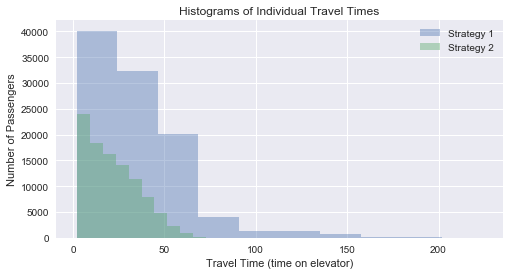

In [10]:
plt.figure(figsize=(8,4))
sns.distplot(all_waiting_times(strategy1['travels']),label='Strategy 1',kde=False,bins=10)
sns.distplot(all_waiting_times(strategy2['travels']),label='Strategy 2',kde=False,bins=10)
plt.title('Histograms of Individual Travel Times')
plt.ylabel('Number of Passengers')
plt.xlabel('Travel Time (time on elevator)')
plt.legend()
plt.show()

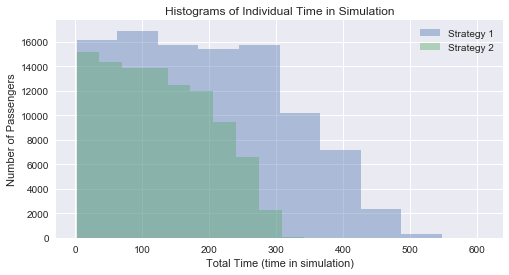

In [11]:
plt.figure(figsize=(8,4))
sns.distplot(all_waiting_times(strategy1['totals']),label='Strategy 1',kde=False,bins=10)
sns.distplot(all_waiting_times(strategy2['totals']),label='Strategy 2',kde=False,bins=10)
plt.title('Histograms of Individual Time in Simulation')
plt.ylabel('Number of Passengers')
plt.xlabel('Total Time (time in simulation)')
plt.legend()
plt.show()